In [ ]:
from PIL import Image
import os

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

##Loading a Pretrained Model
In PyTorch, you can load a pretrained model by specifying the model architecture and the source of the pretrained weights. This is useful when you want to use a model that has already been trained on a large dataset like ImageNet and fine-tune it for your specific task.

In [ ]:
# This method loads the VGG16 model with the default pretrained weights using the older syntax
# model = models.vgg16(pretrained=True)

# This method loads the VGG16 model with the default pretrained weights
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.0MB/s]


When you load a pretrained VGG16 model and print it, you get a detailed structure of the model's architecture.

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

To access intermediate layers in a pretrained model like VGG16, you can tap into different parts of the model, like the features attribute. This attribute holds the sequence of layers that do the feature extraction. By slicing into model.features, you can grab the output from any layer or set of layers, making it easy to work with the model's intermediate outputs.

In [ ]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
model.features[30]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

To access the weight values of a specific layer in a pretrained model like VGG16, you can use the `parameters()` method of the layer.

In [ ]:
for x in model.features[0].parameters():
  print(x.shape)
  # break

torch.Size([64, 3, 3, 3])
torch.Size([64])


In [ ]:
for x in model.features[0].parameters():
  print(x)

Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149e-01,  9.8740

How to freeze weights in a pretrained model?

When you "freeze" the weights in a pretrained model, you are preventing the weights of certain layers from being updated during training. This is useful when you want to use a pretrained model as a feature extractor and only train the final layers (e.g., the classifier) on your specific task.

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
for param in model.classifier.parameters():
    param.requires_grad = False

In [ ]:
dummy_input = torch.zeros(32, *(3, 224, 224))
model(dummy_input).shape

torch.Size([32, 1000])

How to add layers in a pretrained model?

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
num_classes = 10
model.classifier.append(nn.Linear(model.classifier[6].out_features, num_classes))

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): Linear(in_features=1000, out_features=10, bias=True)
)

How to edit layers in a pretrained model?

Editing layers in a pretrained model allows you to modify the architecture to fit your specific task.

For example, if you're working with a pretrained model like VGG16 and want to adapt it for a different number of output classes, you can replace the final fully connected layer (or any other layer) with a new one.

In [ ]:
num_classes = 10
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
  (7): Linear(in_features=1000, out_features=10, bias=True)
)

How to remove layers in a pretrained model?

Removing layers from a pretrained model can be done in a few different ways. One common approach is to modify the model by reassigning parts of its architecture, often using slicing or constructing a new model based on the original but without the unwanted layers.

```
FQA: Does it affect pretrained weights?
ANS: No, it does not affect the pretrained weights of the layers that are retained. These layers will continue to hold their pretrained weights, ensuring that their learned features are preserved. However, any removed layers will obviously lose their associated weights.
```

In [ ]:
list(model.classifier.children())[:-1]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [ ]:
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)

##Custom Pretrained Model

To build a custom pretrained model in PyTorch, you can create a new class that inherits from `nn.Module`. This approach allows you to modify and extend existing pretrained models to fit your specific needs. Below is an example of how to do this using the VGG16 architecture.

In [ ]:
class customVGG16(nn.Module):
    def __init__(self, input_size=(3,224,224), num_classes=10):
        super(customVGG16, self).__init__()

        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.vgg16.flatten = nn.Flatten()

        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = False

        self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[-1].in_features, num_classes)

    def forward(self, x):
      x = self.vgg16.features(x)
      x = self.vgg16.avgpool(x)
      x = self.vgg16.flatten(x)
      x = self.vgg16.classifier(x)
      return F.log_softmax(x, dim=1)

How do you troubleshoot and debug your custom model?

Using a dummy input is a common approach to test the forward pass of your model without needing real data.<br> `Note: The dummy input should have the same dimensions as your actual data.`

In [ ]:
dummy_input = torch.zeros(32, *(3, 224, 224))

In [ ]:
VGG16 = customVGG16()
VGG16(dummy_input).shape

torch.Size([32, 10])

## Preparing Dataset & DataLoader

In [ ]:
!git clone https://github.com/NextGen-AI-Camp/curriculum.git

Cloning into 'curriculum'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 341 (delta 78), reused 78 (delta 22), pack-reused 181
Receiving objects: 100% (341/341), 41.74 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
!mv /content/curriculum/Dataset/thai-handwritten-dataset/thai-handwritten-dataset.zip .

In [ ]:
!unzip thai-handwritten-dataset.zip

Archive:  thai-handwritten-dataset.zip
   creating: thai-handwritten-dataset/
   creating: thai-handwritten-dataset/0/
  inflating: thai-handwritten-dataset/0/0098326c-aa9e-410d-b949-e13d3cd74cfd.png  
  inflating: thai-handwritten-dataset/0/02415aec-d4a3-4762-a1e5-bf4fe584aa66.png  
  inflating: thai-handwritten-dataset/0/051d7c9a-2b54-4e73-9d0b-3fa75dcf1539.png  
  inflating: thai-handwritten-dataset/0/05587e2a-e6f1-4191-8246-61e3f1cf59e9.png  
  inflating: thai-handwritten-dataset/0/09165777-8ac1-4638-bf06-741896c7e1b9.png  
  inflating: thai-handwritten-dataset/0/0a51150d-0afd-455e-9782-9141b68475ed.png  
  inflating: thai-handwritten-dataset/0/0a8e39b3-4d7c-4050-a25d-746a6b8de686.png  
  inflating: thai-handwritten-dataset/0/0b48e328-0e73-4946-8fe5-c2324cf55c88.png  
  inflating: thai-handwritten-dataset/0/0b7155a7-4e52-4485-a675-d53397049917.png  
  inflating: thai-handwritten-dataset/0/0f14b574-daf6-4a22-ae06-86eaeee72efa.png  
  inflating: thai-handwritten-dataset/0/12a710d6-87

To work with a custom dataset in PyTorch, you typically need to create a custom `Dataset` class and use a `DataLoader` to efficiently manage batching and shuffling. Below is an example of how to prepare a dataset and dataloader for training a model.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for subdir in os.scandir(root_dir):
            if subdir.is_dir():
                label = int(subdir.name)
                for file in os.scandir(subdir.path):
                    if file.is_file():
                        self.samples.append((file.path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

To handle batching, shuffling, and other data-loading tasks, you wrap your dataset in a `DataLoader`

In [ ]:
class ReverseIntensity:
    def __call__(self, x):
        return 1 - x

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ReverseIntensity(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

path = '/content/thai-handwritten-dataset'
dataset = CustomDataset(path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader, test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True), DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

To preview the first batch of images from your DataLoader, you can use the following code.

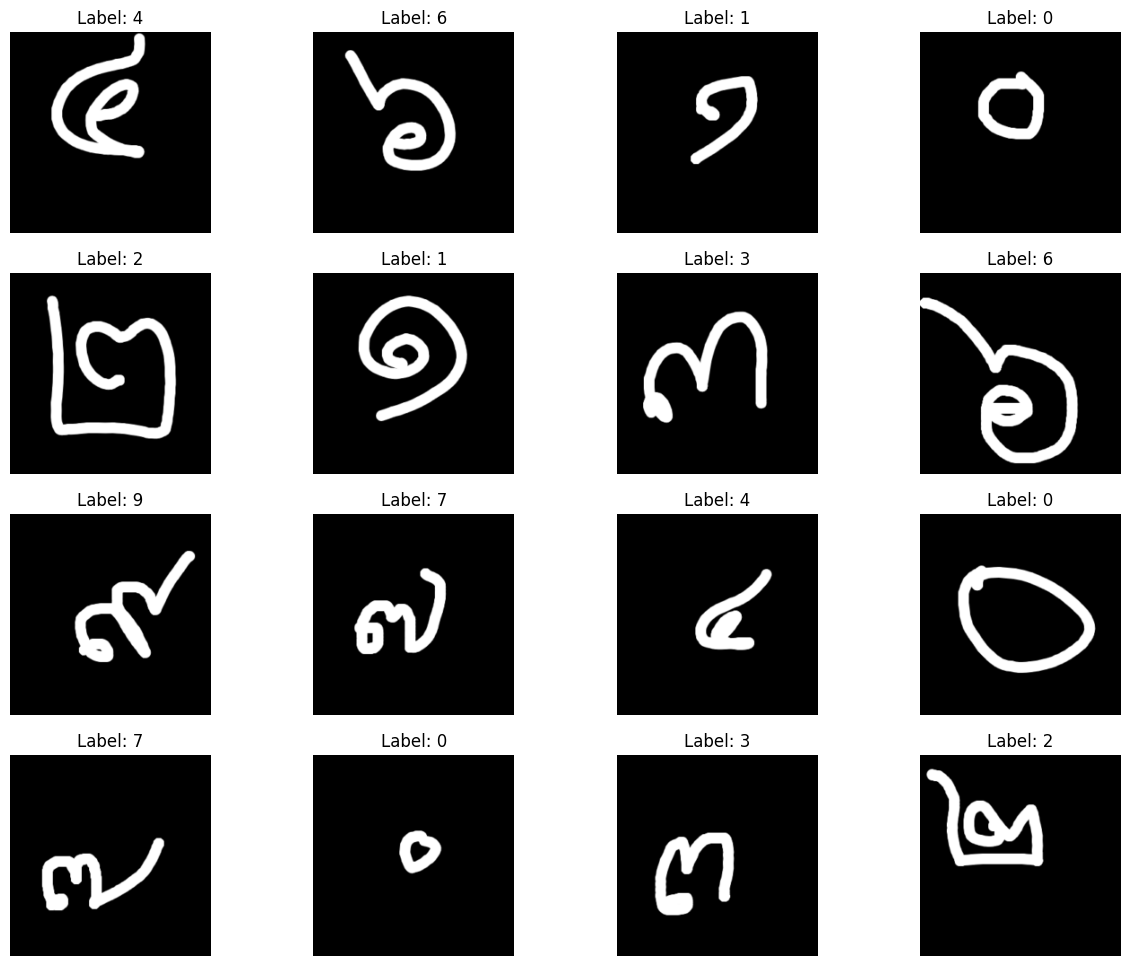

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4x4 grid for 16 images
axes = axes.flatten()

for idx, (img ,label, ax) in enumerate(zip(images, labels, axes)):
    image = img.numpy().transpose((1, 2, 0))

    # Shift the image so the minimum value is 0
    shifted_image = image - image.min()

    # Scale the image to fit within [0, 1]
    normalized_image = shifted_image / shifted_image.max()

    ax.imshow(normalized_image, cmap='seismic')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

##Training the Custom Model

To train your custom model in PyTorch, you'll need to define a training loop that handles the forward pass, computes the loss, backpropagates the gradients, and updates the model's parameters.

In [ ]:
def train(model, optimizer, epochs, device, train_loader, test_loader):
    model.to(device)
    for epoch in range(epochs):

        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        train_bar = tqdm(train_loader,desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',unit='batch')

        for batch_idx, (data, target) in enumerate(train_bar):

            data, target = data.to(device), target.to(device)

            output = model(data)
            optimizer.zero_grad()

            loss = F.nll_loss(output, target)
            loss.backward()

            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(target.view_as(pred)).sum().item()

            train_loss += F.nll_loss(output, target, reduction='sum').item()
            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)

        model.eval()
        test_correct, test_loss = 0, 0

        with torch.no_grad():

            test_bar = tqdm(test_loader,desc=f'📄Testing  Epoch [{epoch+1}/{epochs}]',unit='batch')

            for data, target in test_bar:
                data, target = data.to(device), target.to(device)
                output = model(data)

                test_loss += F.nll_loss(output, target, reduction='sum').item()

                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)

            print('\nTrain set:\tAverage loss: {:.4f}, Accuracy: {}/{}\t({:.0f}%)'.format(
            train_loss, train_correct, len(train_loader.dataset), 100. * train_correct / len(train_loader.dataset)))
            print('Test set:\tAverage loss: {:.4f}, Accuracy: {}/{}\t\t({:.0f}%)\n'.format(
            test_loss, test_correct, len(test_loader.dataset), 100. * test_correct / len(test_loader.dataset),))

In [ ]:
model = customVGG16()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model, optimizer, epochs, device, train_loader, test_loader)

📄Testing  Epoch [1/5]: 100%|██████████| 11/11 [00:02<00:00,  4.04batch/s]



Train set:	Average loss: 1.6609, Accuracy: 665/1400	(48%)
Test set:	Average loss: 1.1249, Accuracy: 255/350		(73%)



📄Testing  Epoch [2/5]: 100%|██████████| 11/11 [00:02<00:00,  4.27batch/s]



Train set:	Average loss: 1.0111, Accuracy: 974/1400	(70%)
Test set:	Average loss: 0.8500, Accuracy: 269/350		(77%)



📄Testing  Epoch [3/5]: 100%|██████████| 11/11 [00:02<00:00,  4.32batch/s]



Train set:	Average loss: 0.8338, Accuracy: 1051/1400	(75%)
Test set:	Average loss: 0.7275, Accuracy: 286/350		(82%)



📄Testing  Epoch [4/5]: 100%|██████████| 11/11 [00:02<00:00,  4.31batch/s]



Train set:	Average loss: 0.7283, Accuracy: 1103/1400	(79%)
Test set:	Average loss: 0.6525, Accuracy: 289/350		(83%)



📄Testing  Epoch [5/5]: 100%|██████████| 11/11 [00:02<00:00,  3.82batch/s]


Train set:	Average loss: 0.6497, Accuracy: 1127/1400	(80%)
Test set:	Average loss: 0.5964, Accuracy: 296/350		(85%)



## Visualizing Feature Maps

FeatureExtractor is class that hooks into the forward pass of the model and captures the outputs (feature maps) of specified layers. Below is the code for the FeatureExtractor class, followed by an example of how to use it to visualize feature maps.

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map!

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                print(layer_name)
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output.clone())
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

First, it's important to understand the structure of your model. By printing the model, you can see how the layers are organized:

In [ ]:
model

customVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

To visualize feature maps, you need to select the layers you're interested in. Based on the model structure, <br> you might choose layers like `vgg16.features.0, vgg16.features.10, etc,.`

In [ ]:
targets = [name for name, _ in model.named_modules() if 'features.' in name]
targets

['vgg16.features.0',
 'vgg16.features.1',
 'vgg16.features.2',
 'vgg16.features.3',
 'vgg16.features.4',
 'vgg16.features.5',
 'vgg16.features.6',
 'vgg16.features.7',
 'vgg16.features.8',
 'vgg16.features.9',
 'vgg16.features.10',
 'vgg16.features.11',
 'vgg16.features.12',
 'vgg16.features.13',
 'vgg16.features.14',
 'vgg16.features.15',
 'vgg16.features.16',
 'vgg16.features.17',
 'vgg16.features.18',
 'vgg16.features.19',
 'vgg16.features.20',
 'vgg16.features.21',
 'vgg16.features.22',
 'vgg16.features.23',
 'vgg16.features.24',
 'vgg16.features.25',
 'vgg16.features.26',
 'vgg16.features.27',
 'vgg16.features.28',
 'vgg16.features.29',
 'vgg16.features.30']

Create an instance of the FeatureExtractor

In [ ]:
feature_extractor = FeatureExtractor(model=model, target_layers=targets)

vgg16.features.0
vgg16.features.1
vgg16.features.2
vgg16.features.3
vgg16.features.4
vgg16.features.5
vgg16.features.6
vgg16.features.7
vgg16.features.8
vgg16.features.9
vgg16.features.10
vgg16.features.11
vgg16.features.12
vgg16.features.13
vgg16.features.14
vgg16.features.15
vgg16.features.16
vgg16.features.17
vgg16.features.18
vgg16.features.19
vgg16.features.20
vgg16.features.21
vgg16.features.22
vgg16.features.23
vgg16.features.24
vgg16.features.25
vgg16.features.26
vgg16.features.27
vgg16.features.28
vgg16.features.29
vgg16.features.30


In [ ]:
images, labels = next(iter(test_loader))
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
input_data = images[0].unsqueeze(0).to(device)
input_data.shape

torch.Size([1, 3, 224, 224])

In [ ]:
input_data[0].shape

torch.Size([3, 224, 224])

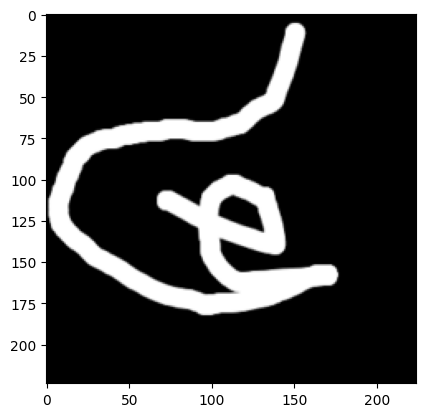

In [ ]:
plt.imshow(input_data[0].cpu().numpy().transpose(1, 2, 0))

Pass a sample input through the model to extract feature maps

In [ ]:
extracted_features = feature_extractor(input_data)

for idx, feature in enumerate(extracted_features):
    print(f"Feature from layer {targets[idx]}: {feature.shape}")

Feature from layer vgg16.features.0: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.1: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.2: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.3: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.4: torch.Size([1, 64, 112, 112])
Feature from layer vgg16.features.5: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.6: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.7: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.8: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.9: torch.Size([1, 128, 56, 56])
Feature from layer vgg16.features.10: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.11: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.12: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.13: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.14: torch.Size([1, 256, 5

for example: we wil focusing on a specific convolutional layer output from the VGG16 model.

In [ ]:
conv_output = extracted_features[8].squeeze(0) # vgg16.features.7
conv_output.shape

torch.Size([128, 112, 112])

Set Up the Plotting Grid

In [ ]:
# Create a figure to plot the output channels
num_channels = conv_output.shape[0]
num_cols = 8
num_rows = (num_channels + num_cols - 1) // num_cols

num_channels, num_cols, num_rows

(128, 8, 16)

displaying the feature maps as grayscale images in a grid format.

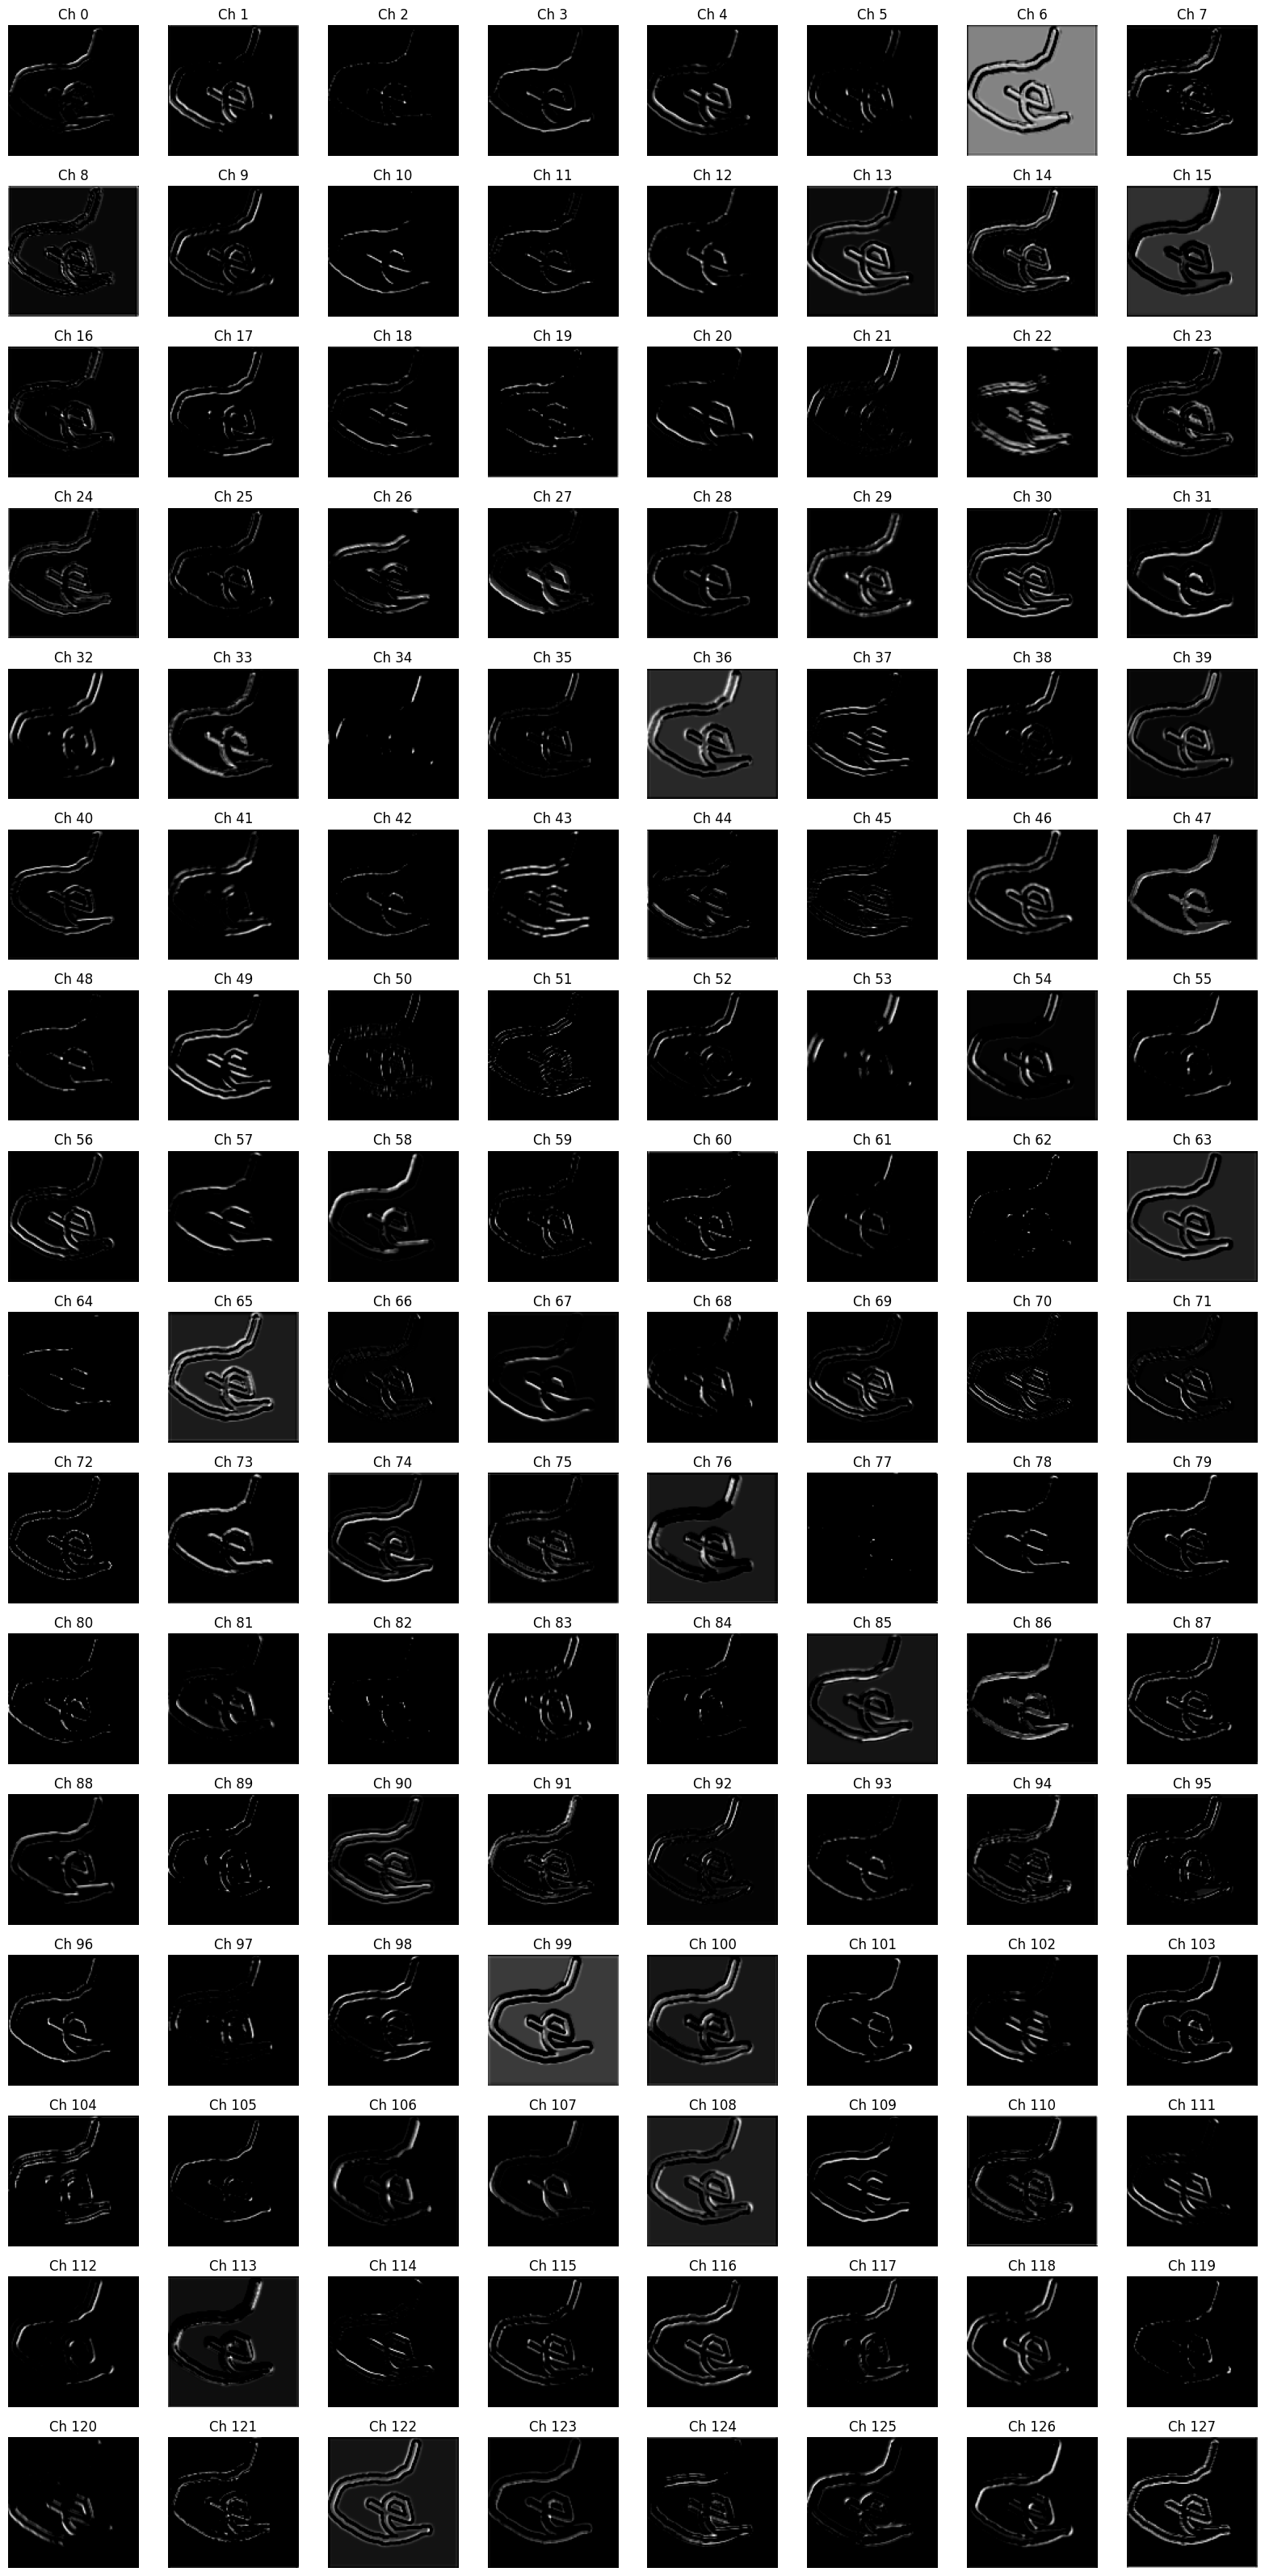

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
axes = axes.flatten()  # Flatten to easily iterate through

for i in range(num_channels):
    ax = axes[i]
    channel_data = conv_output[i].detach().cpu().numpy()
    # print(np.unique(channel_data))

    ax.imshow(channel_data, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Ch {i}')

# Hide any remaining subplots if there are any
for i in range(num_channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Extra curriculum!

 (MTL) multi-task learning technique

Multi-Task Learning is a machine learning technique where a single model is trained to perform multiple tasks simultaneously.<br>

Instead of training separate models for each task, MTL leverages shared representations and parameters to improve learning efficiency and generalization. The idea is that by learning related tasks together, the model can capture more robust features that are beneficial across all tasks, leading to better performance and faster convergence.

How Does MTL Work?

In MTL, the model typically consists of:

- Shared Layers: These layers are common across all tasks and are responsible for extracting general features from the input data. These features are useful for all tasks being solved.
- Task-Specific Layers: After the shared layers, the model branches out into different layers or modules that are specific to each task. These layers are responsible for producing outputs tailored to each particular task.

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU()
        )

        # Task-specific layers
        self.task1 = nn.Linear(50, 10)
        self.task2 = nn.Linear(50, 5)

    def forward(self, x):

        # Forward pass through shared layers
        x = self.shared(x)

        # Forward pass through task-specific layers
        out1 = self.task1(x)
        out2 = self.task2(x)

        return F.log_softmax(out1, dim=1), F.log_softmax(out2, dim=1)


To train a Multi-Task Learning (MTL) model, you need to consider the fact that the model has multiple outputs, each corresponding to a different task. Each task has its own loss function, and these losses are combined to update the model's shared parameters.

In [ ]:
# Define loss functions and optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch_idx, (data, target1, target2) in enumerate(train_loader):

        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)

        output1, output2 = model(data)
        optimizer.zero_grad()

        loss_task1 = F.nll_loss(output1, target1)
        loss_task2 = F.nll_loss(output2, target2)

        # Combine the losses (you can optionally weight them)
        loss = loss_task1 + loss_task2

        # Optional: Apply different weights to each task's loss
        # lambda_task1, lambda_task2 = 0.1, 0.9
        # loss = lambda_task1 * loss_task1 + lambda_task2 * loss_task2

        loss.backward()
        optimizer.step()

MTL is particularly useful in scenarios where tasks are related and can benefit from shared representations, such as in multi-label classification, object detection, and natural language processing.

# GOOD LUCK HAVE FUN!